# Gene biomarker selection using RFE
### Author: Shehbeel Arif
### Purpose: To find a set of genes most predictive of frailty based on the muscle gene expression data.

---

## Load libraries

In [1]:
# Library for data handling
import numpy as np
import pandas as pd

# Data preprocessing
from sklearn.preprocessing import LabelEncoder

# Library for performing RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
#from sklearn.feature_selection import RFE

# Import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
# Import Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression

# Import sklearn library to assess model accuracy
from sklearn.model_selection import cross_val_score

# Library for visualizations
import matplotlib.pyplot as plt
import seaborn as sns


## Data Preprocessing

In [33]:
# Load data
meta = pd.read_csv('/Users/shehbeel/Documents/frailty-clinical-model/data/GSE144304_meta.txt', delimiter='\t')
counts = pd.read_csv('/Users/shehbeel/Documents/frailty-clinical-model/analyses/01-convert-ensembl-ids/results/GSE144304_raw_counts_with_genes.csv', index_col='gene_symbol')
de_df = pd.read_csv('/Users/shehbeel/Documents/frailty-clinical-model/analyses/04-de-analysis/results/FrailvAll_DEG_mrna.csv')

# Transpose counts
counts = counts.T

# Select DE genes that have LFC < -1 or LFC > 1 and p<0.05
de_df = de_df[de_df['pvalue'] < 0.05]
de_df = de_df[de_df['log2FoldChange'].abs() > 1]
de_genes = de_df['Gene']

filtered_counts = counts[de_genes]
filtered_counts = filtered_counts.reset_index()

# Merge counts and meta data
df = pd.merge(meta, filtered_counts, left_on='sample_id', right_on='index').drop(['index'], axis=1)
df

# Encode Gender
#le = LabelEncoder()
#df['gender'] = le.fit_transform(df['gender'])

# Drop sample_id, frailty columns
df = df.drop(['sample_id', 'condition', 'gender'], axis=1)
df

,frailty,ITLN1,LEP,PEX5L,LINC02660,MAL2,KLB,EGFL6,MRAP,TEX56P,...,NPR3,GBP6,NPAS4,WFDC21P,XCR1,CRADD-AS1,IGFN1,AHRR,OPRD1,CYP1A1
0,1,29,366,0,0,30,106,411,17,0,...,72,0,0,0,0,0,35,2,0,0
1,1,2,66,1,0,1,6,4,4,0,...,25,0,0,0,1,0,888,2,2,1
2,1,0,77,2,1,8,11,12,6,4,...,28,0,0,0,0,0,55,4,5,8
3,1,0,4,7,4,2,1,1,1,3,...,11,0,0,0,0,0,172,1,0,6
4,1,0,2,0,1,0,1,0,1,1,...,36,0,0,1,0,0,1048,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0,0,3,0,0,0,0,0,0,0,...,58,2,2,0,0,0,2028,2,3,73
76,0,0,1,0,0,0,1,0,0,0,...,424,0,0,1,0,2,14595,2,21,116
77,0,0,0,1,0,0,0,2,1,0,...,18,10,5,0,0,0,551,0,3,1
78,0,0,0,1,0,0,0,0,1,0,...,96,1,0,0,1,0,7005,0,0,0


In [34]:
# Split the dataset into training data and labels
X = df.loc[:, df.columns != 'frailty'].values
y = df.loc[:, df.columns == 'frailty'].values.ravel()

# Save feature names
features = df.loc[:, df.columns != 'frailty'].columns.to_list()

# Sanity check
print(X[:5])
print(y[:5])

[[ 29 366   0 ...   2   0   0]
 [  2  66   1 ...   2   2   1]
 [  0  77   2 ...   4   5   8]
 [  0   4   7 ...   1   0   6]
 [  0   2   0 ...   1   0   3]]
[1 1 1 1 1]


---

## Automated Feature Selection using RFE-CV

In [35]:
rfecv = RFECV(estimator=RandomForestClassifier())
model = RandomForestClassifier()

pipeline = Pipeline([('Feature Selection', rfecv), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=123)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.785

In [28]:
# TEMP
rfecv = RFECV(estimator=RandomForestClassifier())
model = RandomForestClassifier()

pipeline = Pipeline([('Feature Selection', rfecv), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=123)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.78375

In [36]:
# Run RFE-CV pipeline
pipeline.fit(X, y)

Pipeline(steps=[('Feature Selection',
                 RFECV(estimator=RandomForestClassifier())),
                ('Model', RandomForestClassifier())])

In [37]:
print('Optimal number of features : %d' % rfecv.n_features_)

Optimal number of features : 164


In [43]:
#rfecv.support_
rfecv_df = pd.DataFrame(rfecv.ranking_,index=features,columns=['Rank']).sort_values(by='Rank',ascending=True)
rfecv_df.to_csv('/Users/shehbeel/Documents/frailty-clinical-model/analyses/03-rfe-feature-selection/results/rfecv_selected_features_2.csv')
rfecv_df.head()

,Rank
ITLN1,1
SMCO2,1
CYP3A5,1
CDHR4,1
NME9,1


In [44]:
rfecv_df

,Rank
ITLN1,1
SMCO2,1
CYP3A5,1
CDHR4,1
NME9,1
...,...
SPATA9,56
COL19A1,57
CYP1A1,58
CCL16,59


/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


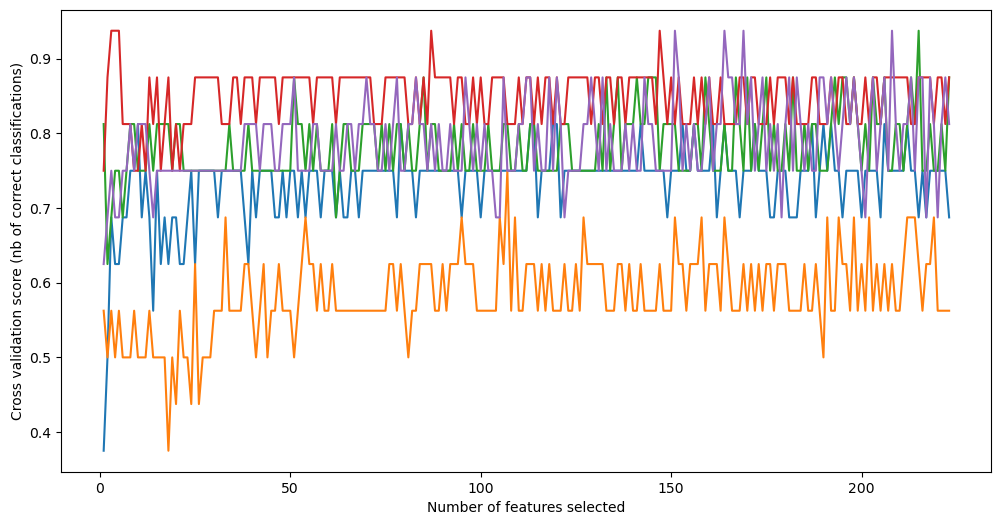

In [39]:
# Visualize the recursive feature elimination process
plt.figure(figsize=(12,6))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (nb of correct classifications)')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [40]:
rfecv_rank_df = pd.DataFrame(rfecv.ranking_, index=features, columns=['Rank']).sort_values(by='Rank', ascending=True)
rfecv_rank_df.head()
rfecv_rank_df.to_csv('/Users/shehbeel/Documents/frailty-clinical-model/analyses/03-rfe-feature-selection/results/rfecv_selected_features_2.csv')

In [42]:
rfecv_rank_df

,Rank
ITLN1,1
SMCO2,1
CYP3A5,1
CDHR4,1
NME9,1
...,...
SPATA9,56
COL19A1,57
CYP1A1,58
CCL16,59


In [41]:
rfecv_cols = ['frailty'] + rfecv_rank_df[rfecv_rank_df['Rank']==1].index.to_list()
df[rfecv_cols]
#df[rfecv_cols].to_csv('pbta_rfecv_selected_features_df.csv')

,frailty,ITLN1,SMCO2,CYP3A5,CDHR4,NME9,CAPN9,KCNE5,LINC02449,EFNA5,...,STAP1,GDF5,SNX32,MGST1,SCG2,PICART1,LINC02408,MST1L,ERBB3,PDF
0,1,29,6,3,3,27,0,4,1,21,...,0,5,6,428,1,2,5,0,143,16
1,1,2,0,0,2,10,2,2,1,5,...,2,3,4,105,3,0,0,1,4,26
2,1,0,3,2,0,34,2,4,2,10,...,1,0,2,113,3,1,7,1,171,9
3,1,0,1,3,2,25,1,0,1,6,...,1,1,0,53,4,4,10,0,81,33
4,1,0,1,0,0,3,4,0,0,11,...,2,1,4,31,2,0,6,0,9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0,0,0,0,0,7,0,0,1,9,...,0,0,1,6,0,3,3,2,2,1
76,0,0,0,1,1,3,0,0,1,3,...,0,0,0,9,0,0,8,0,5,0
77,0,0,5,0,1,16,0,1,0,2,...,0,2,0,17,0,0,5,2,202,0
78,0,0,0,2,0,2,0,2,1,5,...,0,0,1,17,3,0,7,3,43,5


---